In [1]:
from openseespy.opensees import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidades import *
from parametros import *
import opsvis as opsv

In [2]:
wipe()
model('basic', '-ndm', 3, '-ndf', 6)

In [3]:
# Concreto Cortante
uniaxialMaterial('Elastic', 3, G)
# Concreto confinado          tag  f'c   ec0     f'cu   ecu
uniaxialMaterial('Concrete02', 4, fpc1, epsc01, fpcu1, epsU1, lambda1, ft1, Ets)
# Concreto no confinado
uniaxialMaterial('Concrete02', 5, fpc2, epsc02, fpcu2, epsU2, lambda1, ft2, Ets)
# Acero de refuerzo       tag  fy  E0  b
uniaxialMaterial('Steel02', 6, fy, Es, 0.01, 18, 0.925, 0.15)

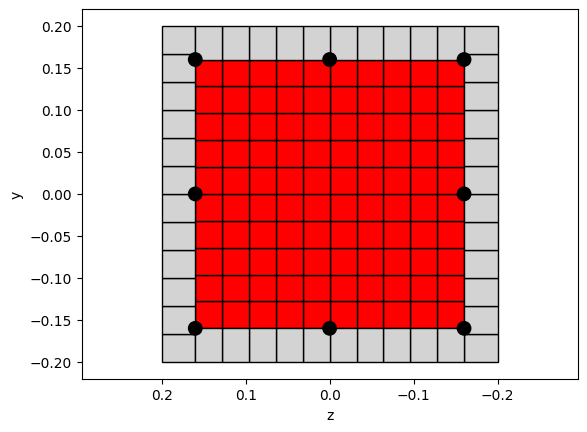

In [4]:
l1, l2 = 0.4, 0.4

# Sección tipo fibra para Columna
cuant, nc_bars = 0.01, 8
As = l1*l2*cuant/nc_bars
Ac, ρlc, Izc, Iyc, k, Jc = prop_col(l1, l2) # Función que devuelve propiedades de la columna
y1 = l1/ 2.0
z1 = l2/ 2.0

n_y = int((y1)/cover*2)
n_z = int((z1)/cover*2)

fib_sec_c = [['section', 'Fiber', 1, '-GJ', G*Jc],
              ['patch', 'rect', 4, n_y, n_z, cover - y1, cover - z1, y1 - cover, z1 - cover], # Patch 1
              ['patch', 'rect', 5, n_y+2, 1, -y1, z1 - cover, y1, z1], # Patch 2
              ['patch', 'rect', 5, n_y+2, 1, -y1, -z1, y1, cover - z1], # Patch 3
              ['patch', 'rect', 5, 1, n_z, -y1, cover - z1, cover - y1, z1 - cover], # Patch 4
              ['patch', 'rect', 5, 1, n_z, y1 -cover, cover - z1, y1, z1 - cover], # Patch 5
              ['layer', 'straight', 6, 3, As, y1 - cover,
              z1 - cover, y1 - cover, cover - z1],
              ['layer', 'straight', 6, 2, As, 0.0, z1 - cover, 0.0, cover - z1],
              ['layer', 'straight', 6, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1]]

# Ploteo de sección
matcolor = ['r', 'lightgrey', 'gold', 'r', 'lightgrey', 'gold']
opsv.plot_fiber_section(fib_sec_c, matcolor=matcolor)
plt.axis('equal')
plt.show()
plt.close()

# Crear sección tipo fibra en OpenSees
for li in fib_sec_c:

    if li[0] == 'section':
        # section('Fiber',1,'-GJ', G*Jc)
        eval('%s("%s",%s,"%s",%s)' % tuple(li))
    else:
        eval('%s("%s",%s,%s,%s,%s,%s,%s,%s)' % tuple(li))

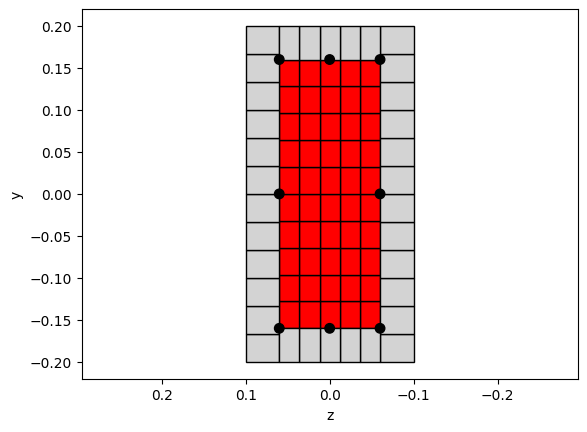

In [5]:
b,h = 0.2, 0.4

# Sección tipo fibra para Viga
cuant, nc_bars = 0.01, 8
As = b*h*cuant/nc_bars
Av, ρlv, Izv, Iyv, k, Jv = prop_vig(b, h) # Función que devuelve propiedades de la viga
y1 = h / 2.0
z1 = b / 2.0

n_y = int((y1)/cover*2)  # Número de divisiones en la dirección Y
n_z = int((z1)/cover*2)  # Número de divisiones en la dirección Z

fib_sec_v = [['section', 'Fiber', 2, '-GJ', G*Jv],
              ['patch', 'rect', 4, n_y, n_z, cover - y1, cover - z1, y1 - cover, z1 - cover],
              ['patch', 'rect', 5, n_y+2, 1, -y1, z1 - cover, y1, z1],
              ['patch', 'rect', 5, n_y+2, 1, -y1, -z1, y1, cover - z1],
              ['patch', 'rect', 5, 1, n_z, -y1, cover - z1, cover - y1, z1 - cover],
              ['patch', 'rect', 5, 1, n_z, y1 -cover, cover - z1, y1, z1 - cover],
              ['layer', 'straight', 6, 3, As, y1 - cover,
              z1 - cover, y1 - cover, cover - z1],
              ['layer', 'straight', 6, 2, As, 0.0, z1 - cover, 0.0, cover - z1],
              ['layer', 'straight', 6, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1]]

# Ploteo de sección
matcolor = ['r', 'lightgrey', 'gold', 'r', 'lightgrey', 'gold']
opsv.plot_fiber_section(fib_sec_v, matcolor=matcolor)
plt.axis('equal')
plt.show()
plt.close()

# Crear sección tipo fibra en OpenSees
for li in fib_sec_v:
    if li[0] == 'section':
        eval('%s("%s",%s,"%s",%s)' % tuple(li))
    else:
        eval('%s("%s",%s,%s,%s,%s,%s,%s,%s)' % tuple(li))

In [6]:
def funtion_mx(L, t):
    Lmx = L*m   # Longitud del muro
    t = t*m  # Espesor del muro
    ancho = 50*cm  # Discretización del muro
    mufx = int(round(Lmx/ancho))
    ttx = np.zeros(mufx)
    ttx[:] = t # Arreglo de espesores
    wwx = np.zeros(mufx)
    wwx[:] = Lmx/(mufx) # Arreglo de anchos
    ρρx = np.zeros(mufx)
    ρρx[:] = 0.0064  # Cuantía vertical en muros
    ρρx[0], ρρx[-1] = 0.01, 0.01  # Cuantía vertical en núcleo
    concx = np.zeros(mufx)
    concx[:] = 5 # Concreto sin confinar
    concx[0], concx[-1] = 4, 4 # Concreto confinado
    acerox = np.zeros(mufx)
    acerox[:] = 6 # Modelo No Lineal del acero
    return mufx, ttx, wwx, ρρx, concx, acerox

In [7]:
# Creamos los nodos
Lx = 1.0
node(1, *[0.,0.,0.])
node(2, *[3.,0.,0.])
node(3, *[3.+Lx,0.,0.])
node(4, *[0.,0.,3.])
node(5, *[3.,0.,3.])
node(6, *[3.+Lx,0.,3.])
node(7, *[0.,0.,6.])
node(8, *[3.,0.,6.])
node(9, *[3.+Lx,0.,6.])

In [8]:
fixY(0.0, *[0, 1, 0, 0, 0, 0], '-tol', 1e-6)
fixZ(0.0, *[1, 1, 1, 1, 1, 1], '-tol', 1e-6)

In [9]:
# Establecemos transformación geométrica
geomTransf('PDelta', int(1), *[1, 0, 0]) # Columna
geomTransf('Linear', int(2), *[1, -1, 0]) # Vigas

In [10]:
# Lobatto integration
ni = 5  # Número de puntos de integración a lo largo del elemento
# beamIntegration('Lobatto', tag, secTag, N)
beamIntegration('Lobatto', 1, 1, ni)

# beamIntegration('Lobatto', tag, secTag, N)
beamIntegration('Lobatto', 2, 2, ni)

In [11]:
# Creamos los elementos

Ac = l1*l2
element('forceBeamColumn', 1, 1, 4, 1, 1, '-mass', 2400*Ac*m**2 )
element('forceBeamColumn', 2, 4, 7, 1, 1, '-mass', 2400*Ac*m**2 )

Av = b*h
element('forceBeamColumn', 3, 4, 5, 2, 2, '-mass', 2400*Av*m**2)
element('forceBeamColumn', 4, 7, 8, 2, 2, '-mass', 2400*Av*m**2)

muf, tt, ww, ρρ, conc, acero = funtion_mx(Lx, 0.2)
element('MVLEM_3D', 5, 3, 2, 5, 6, int(muf), '-thick', *tt[:], '-width', *ww[:],'-rho', *ρρ[:],
        '-matConcrete', *map(int,conc), '-matSteel', *map(int,acero), '-matShear', int(3), '-Poisson', 0.2, '-Density', ρ)
element('MVLEM_3D', 6, 6, 5, 8, 9, int(muf), '-thick', *tt[:], '-width', *ww[:],'-rho', *ρρ[:],
        '-matConcrete', *map(int,conc), '-matSteel', *map(int,acero), '-matShear', int(3), '-Poisson', 0.2, '-Density', ρ)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

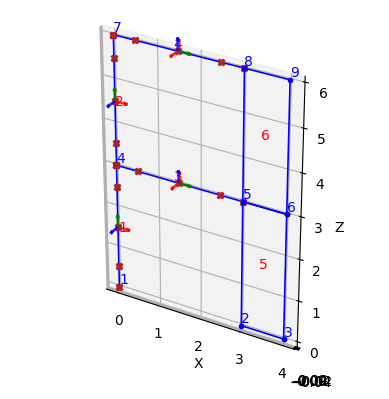

In [12]:
opsv.plot_model('nodes','elements')

T[1]: 0.22656
T[2]: 0.04200
T[3]: 0.01596
T[4]: 0.01552


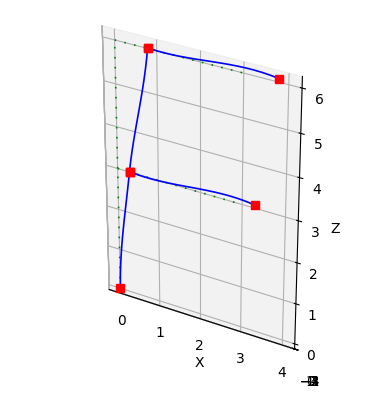

In [13]:
# ASIGNACIÓN DE MASAS Y MODOS DE VIBRACIÓN
aPlanta = (3.+Lx)*5.
Carga = wTotal*aPlanta*m**2
mass(4, Carga/3, Carga/3, 0.0)
mass(5, Carga/3, Carga/3, 0.0)
mass(6, Carga/3, Carga/3, 0.0)
mass(7, Carga/3, Carga/3, 0.0)
mass(8, Carga/3, Carga/3, 0.0)
mass(9, Carga/3, Carga/3, 0.0)

Nmodes = 4

vals = eigen(Nmodes)
Tmodes = np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i] = 2*np.pi/vals[i]**0.5
    print("T[%i]: %.5f" % (i+1, Tmodes[i]))

opsv.plot_mode_shape(1, 100)

In [14]:
timeSeries('Linear', 1)  # tag
pattern('Plain', 1, 1)  # tag, timeSeries_tag

# Peso propio de los elementos
eleLoad('-ele', 1, '-type','-beamUniform', 0.0, 0.0, -ρ*Ac*g)
eleLoad('-ele', 2, '-type','-beamUniform', 0.0, 0.0, -ρ*Ac*g)

eleLoad('-ele', 3, '-type','-beamUniform', -ρ*Av*g, 0.0, 0.0)
eleLoad('-ele', 4, '-type','-beamUniform', -ρ*Av*g, 0.0, 0.0)

dz = 3.
t = 0.2
load(3, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(2, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(5, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(6, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)

load(6, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(5, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(8, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)
load(9, 0., 0., -0.25*dz*Lx*t*ρ*g, 0., 0., 0.)


In [15]:
# Carga viva y muerta sobre los nodos

load(4, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)
load(5, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)
load(6, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)
load(7, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)
load(8, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)
load(9, 0.0, 0.0, -Carga*g/3, 0.0, 0.0, 0.0)

In [16]:
# Análisis de cargas de gravedad
system('UmfPack')
constraints('Transformation')
numberer('RCM')
test('NormDispIncr', 1.0e-12, 10, 3)
algorithm('Newton')
integrator('LoadControl', 0.1)
analysis('Static')
analyze(10)

0

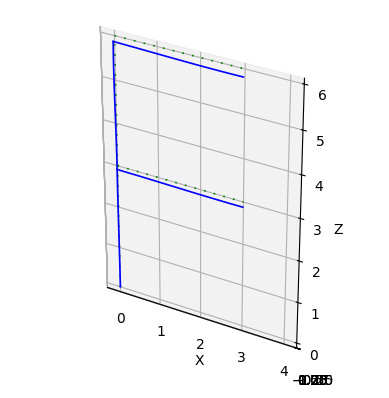

In [17]:
opsv.plot_defo(1000)
plt.show()

In [18]:
vals = eigen(Nmodes)
Tmodes = np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i] = 2*np.pi/vals[i]**0.5
    print("T[%i]: %.5f" % (i+1, Tmodes[i]))

T[1]: 0.22756
T[2]: 0.04217
T[3]: 0.01597
T[4]: 0.01553


In [19]:
base  = [1,2,3]
piso1 = [4,5,6]
col1 = [1]
wall1 = [5]
col2 = [2]
wall2 = [6]

In [20]:
wipeAnalysis()
loadConst('-time', 0.0)

In [21]:
dt = 0.02
accX = np.genfromtxt('1974oct_X.txt')
steps = len(accX)
tFinal = steps*dt # 32.

timeSeries('Path', 2, '-dt', dt, '-values', *accX, '-factor', 2.0*cm)
pattern('UniformExcitation', 2, 1, '-accel', 2)

# damping ratio
damp = 0.04

# # lower frequency
# omega1 = 2 * np.pi / Tmodes[0] # * 0.2
# # upper frequency
# omega2 = 2 * np.pi / Tmodes[3] # * 20
# a0 = 2*damp*omega1*omega2/(omega1 + omega2)
# a1 = 2*damp/(omega1 + omega2)
# print("a0,a1:",a0,a1)
# rayleigh(a0, a1, 0.0, 0.0)

power = 2*np.pi/Tmodes[0]
betaKcomm = 2 * (damp/power)
rayleigh(0.0, 0.0, 0.0, betaKcomm)

constraints('Transformation')
numberer('RCM')
system('UmfPack')
test('NormDispIncr', 1e-8, 100)
algorithm('RaphsonNewton')
integrator('Newmark', 0.5, 0.25)
analysis('Transient')

tests = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 4: 'RelativeNormUnbalance',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
algts = {1:'KrylovNewton', 2: 'SecantNewton' , 4: 'RaphsonNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}

dtA = 0.01
N = int(steps*dt/dtA)
x = np.zeros((N+1,2))
y = np.zeros((N+1,2))
tCurrent = getTime()
k = 0
while tCurrent < tFinal:
  ok = analyze(1, dtA)
  if ok!=0:
    for i in tests:
      test(tests[i],1.0e-8, 1000)
      for j in algts:
        if j < 4:
          algorithm(algts[j],'-initial')
        else:
          algorithm(algts[j])
        print('\n\nIntentando con:',tests[i],algts[j])
        ok = analyze(1, dtA)
        if ok==0: break
      if ok==0: break
  #
  if ok!=0:
    print('\n'+'='*80)
    print('\n\n\nNo se encontró solución!!! Paso: %i, Tiempo: %.2fs\n\n'%(k,tCurrent))
    break

  V1 = 0
  for bi in col1:
    V1 = V1 - eleForce(bi)[0]
  for bi in wall1:
    V1 = V1 - eleForce(bi)[0]
    V1 = V1 - eleForce(bi)[6]

  V2 = 0
  for bi in col2:
    V2 = V2 - eleForce(bi)[0]
  for bi in wall2:
    V2 = V2 - eleForce(bi)[0]
    V2 = V2 - eleForce(bi)[6]

  x[k]=[nodeDisp(5, 1), nodeDisp(8, 1)-nodeDisp(5, 1)]
  y[k]=[V1, V2]

  k = k + 1
  tCurrent = getTime()
  if k % int(N/50) == 0:
    print("Paso: %i, Tiempo: %.2fs"%(k,tCurrent))
    # opsv2.plot_defo(10)
    # plt.show()

Paso: 172, Tiempo: 1.72s
Paso: 344, Tiempo: 3.44s
Paso: 516, Tiempo: 5.16s
Paso: 688, Tiempo: 6.88s
Paso: 860, Tiempo: 8.60s
Paso: 1032, Tiempo: 10.32s
Paso: 1204, Tiempo: 12.04s
Paso: 1376, Tiempo: 13.76s
Paso: 1548, Tiempo: 15.48s
Paso: 1720, Tiempo: 17.20s


after: 100 iterations  current Norm: 6.41478e-05 (max: 1e-08, Norm deltaR: 6467.12)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 18.05
OpenSees > analyze failed, returned: -3 error flag




Intentando con: NormDispIncr KrylovNewton
Paso: 1892, Tiempo: 18.92s
Paso: 2064, Tiempo: 20.64s
Paso: 2236, Tiempo: 22.36s
Paso: 2408, Tiempo: 24.08s
Paso: 2580, Tiempo: 25.80s
Paso: 2752, Tiempo: 27.52s
Paso: 2924, Tiempo: 29.24s
Paso: 3096, Tiempo: 30.96s
Paso: 3268, Tiempo: 32.68s
Paso: 3440, Tiempo: 34.40s
Paso: 3612, Tiempo: 36.12s
Paso: 3784, Tiempo: 37.84s
Paso: 3956, Tiempo: 39.56s
Paso: 4128, Tiempo: 41.28s
Paso: 4300, Tiempo: 43.00s
Paso: 4472, Tiempo: 44.72s
Paso: 4644, Tiempo: 46.44s
Paso: 4816, Tiempo: 48.16s
Paso: 4988, Tiempo: 49.88s
Paso: 5160, Tiempo: 51.60s
Paso: 5332, Tiempo: 53.32s
Paso: 5504, Tiempo: 55.04s
Paso: 5676, Tiempo: 56.76s
Paso: 5848, Tiempo: 58.48s
Paso: 6020, Tiempo: 60.20s
Paso: 6192, Tiempo: 61.92s
Paso: 6364, Tiempo: 63.64s
Paso: 6536, Tiempo: 65.36s
Paso: 6708, Tiempo: 67.08s
Paso: 6880, Tiempo: 68.80s
Paso: 7052, Tiempo: 70.52s
Paso: 7224, Tiempo: 72.24s
Paso: 7396, Tiempo: 73.96s
Paso: 7568, Tiempo: 75.68s
Paso: 7740, Tiempo: 77.40s
Paso: 7912,

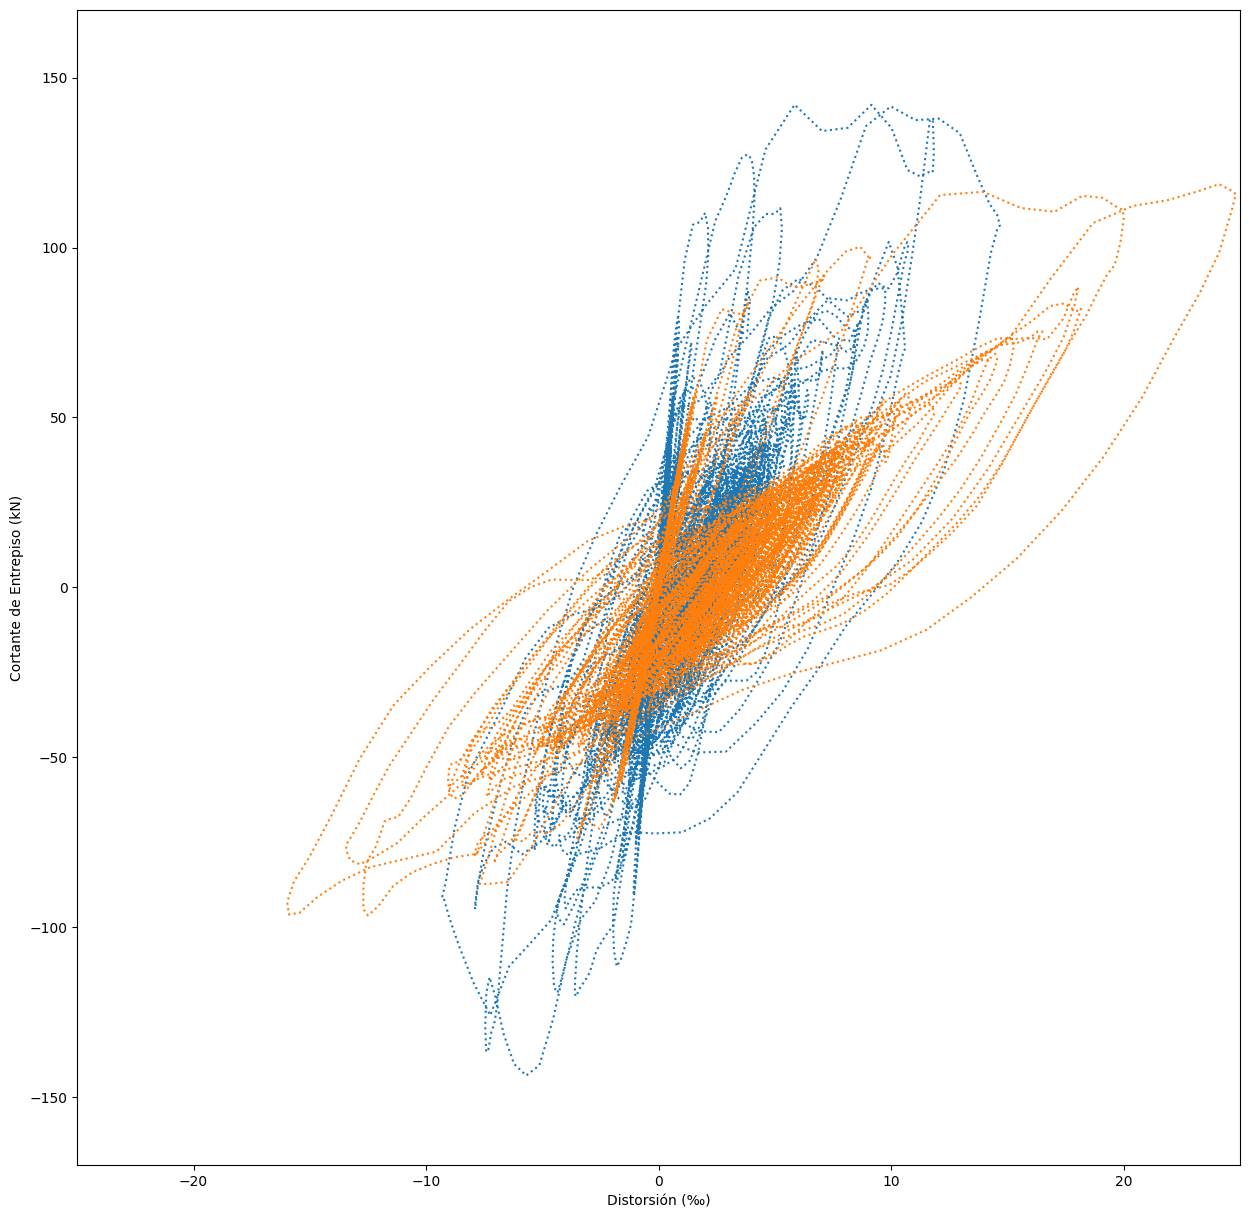

In [22]:
plt.figure(figsize=(15,15))
plt.plot(1000*x[:k,:]/dz, y[:k,:]/kN,':')
plt.axis([-25,25,-170,170])
plt.xlabel('Distorsión (‰)')
plt.ylabel('Cortante de Entrepiso (kN)')
plt.show()

In [23]:
vals = eigen(Nmodes)
Tmodes = np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i] = 2*np.pi/vals[i]**0.5
    print("T[%i]: %.5f" % (i+1, Tmodes[i]))

T[1]: 0.47957
T[2]: 0.04990
T[3]: 0.02784
T[4]: 0.02574
